In [40]:
%load_ext autoreload
%autoreload 2

from tweedejaars_project import load_df
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.metrics import *
from sklearn.linear_model import *


df = load_df()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
print(df.columns)

Index(['datetime', 'import_capacity', 'upward_dispatch_published',
       'downward_dispatch_published', 'min_price_published',
       'mid_price_published', 'max_price_published', 'minute_in_ptu',
       'min_ptu_price_known', 'max_ptu_price_known',
       'igcc_contribution_down_published', 'igcc_contribution_up_published',
       'settlement_price_bestguess', 'time_since_last_two_sided',
       'two_sided_daily_count', 'vwap_avg', 'vwap_std', 'vwap_median',
       'vwap_qty_sum', 'vwap_max', 'hvq_delta', 'PTU', 'target_two_sided_ptu',
       'settlement_price_realized', 'naive_strategy_action', 'forecast_wind',
       'forecast_solar', 'forecast_demand', 'ptu_id',
       'target_two_sided_ptu_alt', 'target_two_sided_ptu_realtime',
       'target_two_sided_ptu_flip'],
      dtype='object')


In [46]:
# Creating features

def features(df):
    # forecast
    df['residual_load'] = df['forecast_demand'] - df['forecast_solar'] - df['forecast_wind']
    df['forecast_solar_delta'] = df['forecast_solar'].diff()
    df['forecast_wind_delta'] = df['forecast_wind'].diff()

    for i in range(0, len(df), 15):
        df.loc[i+1:i+14, 'forecast_solar_delta'] = df['forecast_solar_delta'][i]
        df.loc[i+1:i+14, 'forecast_wind_delta'] = df['forecast_wind_delta'][i]

    # diffs
    df['min_price_diff'] = df['min_price_published'].diff() + df['min_price_published']
    df['downward_dispatch_diff'] = df['downward_dispatch_published'].diff() + df['downward_dispatch_published']
    df['igcc_down_diff'] = df['igcc_contribution_down_published'].diff() + df['igcc_contribution_down_published']
    df['dispatch_diff'] = df['upward_dispatch_published'] - df['downward_dispatch_published']
    df['igcc_diff'] = df['igcc_contribution_up_published'] - df['igcc_contribution_down_published']

    # balance
    df['balance'] = df['residual_load'] # - 

    df['import_zero'] = df['import_capacity'] == 0


    df['import_capacity_left'] = df['import_capacity'] + df['igcc_contribution_down_published'] - df['igcc_contribution_up_published']

    # df['import_capacity_left'] = 0
    # for i in range(1,len(df)):
    #     df.loc[i,'import_capacity_left'] = df['import_capacity_left'][i-1] + df['igcc_contribution_up_published'][i] - df['igcc_contribution_down_published'][i]

    # df.loc[i,'import_capacity_left'] = sum(df['igcc_contribution_up_published'][:i]) - sum(df['igcc_contribution_down_published'][:i])
    return df

_ = features(df)


In [47]:
df1 = df[['datetime','target_two_sided_ptu','minute_in_ptu','forecast_solar', 'forecast_solar_delta','forecast_wind','forecast_wind_delta','residual_load','min_price_published','mid_price_published','max_price_published']]
df2 = df[['minute_in_ptu','target_two_sided_ptu','min_price_published','mid_price_published','max_price_published','downward_dispatch_published','upward_dispatch_published','igcc_contribution_down_published','igcc_contribution_up_published']]
df3 = df[['igcc_contribution_down_published','igcc_contribution_up_published','import_capacity','import_capacity_left','import_zero','target_two_sided_ptu']]
df4 = df[['minute_in_ptu','target_two_sided_ptu','downward_dispatch_published','upward_dispatch_published','import_capacity','import_capacity_left']]

df4.head()

,minute_in_ptu,target_two_sided_ptu,downward_dispatch_published,upward_dispatch_published,import_capacity,import_capacity_left
0,0,False,0.0,0.0,65.4,65.4
1,1,False,0.0,0.0,65.4,65.4
2,2,True,79.0,0.0,65.4,197.4
3,3,True,61.0,0.0,65.4,35.4
4,4,True,43.0,0.0,65.4,-0.6


/home/simen/miniconda3/envs/tweedejaars_project/lib/python3.12/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


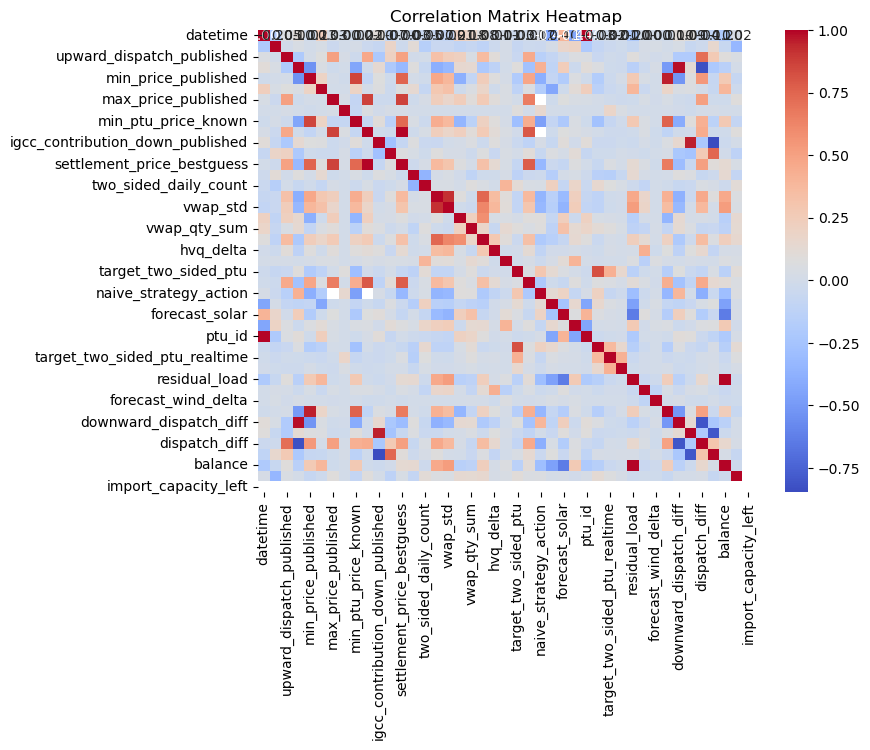

In [44]:
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [45]:
# for i in range(0, len(df), 15):
#     df.loc[i+1:i+14, 'forecast_solar'] = np.nan
#     df.loc[i+1:i+14, 'forecast_wind'] = np.nan

# df['forecast_solar'] = df['forecast_solar'].interpolate(method='cubic')
# df['forecast_wind'] = df['forecast_wind'].interpolate(method='cubic')
# df['forecast_solar_delta'] = df['forecast_solar'].diff()
# df['forecast_wind_delta'] = df['forecast_wind'].diff()